In [0]:
!apt install cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines==2.5.0

In [0]:
import json
import logging
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gym
from stable_baselines.common import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack
from stable_baselines.common.vec_env import VecNormalize
from stable_baselines import A2C
from stable_baselines.common.policies import CnnPolicy

from stable_baselines.results_plotter import load_results, ts2xy

log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

In [0]:
best_mean_reward, n_steps = -np.inf, 0
def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    
    if (n_steps) % 100 == 1:
        # Display frames
        plt.grid(None)
        plt.imshow(_locals["self"].env.render(mode='rgb_array'))
        plt.show()
        #pprint(_locals['self'].graph.get_collection("trainable_variables"))
            
    n_steps += 1
    return True

In [0]:
from pprint import pprint
from google.colab.patches import cv2_imshow

def nature_cnn(scaled_images, **kwargs):
    """Set up the CNN's architecture"""
    
    layer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4, activation='relu', name='c1')(scaled_images)
    layer2 = tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2, activation='relu', name='c2')(layer1)
    layer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', name='c3')(layer2)
    layer4 = tf.keras.layers.Dense(filters=512, activation='relu', name='c4')(tf.keras.layers.Flatten()(layer3))

    return layer4

# PyTorch model from Learn to Interpret Atari Agents
# https://github.com/yz93/Learn-to-Interpret-Atari-Agents/blob/master/model.py
# 
# class DQN_rs(nn.Module):
#     def __init__(self, args, action_space):
#         super().__init__()
#         self.atoms = args.atoms
#         self.action_space = action_space

#         # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
#         self.conv1 = nn.Conv2d(args.history_length, 32, 8, stride=4, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
#         self.conv3 = nn.Conv2d(64, 64, 3)

#         # region-sensitive module (iput_chan, output_chan, kernel_size)
#         self.conv1_attent = nn.Conv2d(64, 512, 1)
#         self.conv2_attent = nn.Conv2d(512, 2, 1)

#         self.fc_h_v = NoisyLinear(3136, args.hidden_size, std_init=args.noisy_std)
#         self.fc_h_a = NoisyLinear(3136, args.hidden_size, std_init=args.noisy_std)
#         self.fc_z_v = NoisyLinear(args.hidden_size, self.atoms, std_init=args.noisy_std)
#         self.fc_z_a = NoisyLinear(args.hidden_size, action_space * self.atoms, std_init=args.noisy_std)

#     def forward(self, x, log=False):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.normalize(x, p=2, dim=1)
#         batch_size = x.size(0)
#         weights = F.elu(self.conv1_attent(x))
#         weights = self.conv2_attent(weights).view(-1, 2, 49)
#         weights = F.softmax(weights.view(batch_size*2,-1), dim=1) #2D tensor by default is also dim 1
#         weights = weights.view(batch_size,2,7,7)

#         #Broadcasting
#         x1 = x * weights[:, :1, :, :]
#         x2 = x * weights[:, 1:, :, :]
#         x = x1 + x2

#         x = x.view(-1, 3136)
#         v = self.fc_z_v(F.relu(self.fc_h_v(x)))  # Value stream
#         a = self.fc_z_a(F.relu(self.fc_h_a(x)))  # Advantage stream
#         v, a = v.view(-1, 1, self.atoms), a.view(-1, self.action_space, self.atoms)
#         q = v + a - a.mean(1, keepdim=True)  # Combine streams
#         if log:  # Use log softmax for numerical stability
#             q = F.log_softmax(q, dim=2)  # Log probabilities with action over second dimension
#         else:
#             q = F.softmax(q, dim=2)  # Probabilities with action over second dimension
#         return q # shape: (-1, self.action_space, self.atoms)


def attention_cnn(scaled_images, **kwargs):
    """Nature CNN with region-sensitive module"""
    
    c1 = tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4, activation='relu', name='c1')(scaled_images)
    c2 = tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2, activation='relu', name='c2')(c1)
    c3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', name='c3')(c2)
    c3 = tf.keras.backend.l2_normalize(c3, axis=-1)  # TODO Axis correct?
    

    a1 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, activation='elu', name='a1')(c3)
    a2 = tf.keras.layers.Conv2D(filters=2, kernel_size=1, strides=1, activation='softmax', name='a2')(a1)
    
    # TODO Multiplications correct?
    c4 = tf.multiply(c3, tf.expand_dims(a2[:, :, :, 0], axis=-1)) 
    c4 += tf.multiply(c3, tf.expand_dims(a2[:, :, :, 1], axis=-1)) 

    d = tf.keras.layers.Dense(512, activation='relu', name='d')(tf.keras.layers.Flatten()(c4))
    
    return d

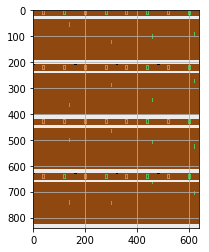

---------------------------------
| explained_variance | -3.3     |
| fps                | 151      |
| nupdates           | 1        |
| policy_entropy     | 1.79     |
| total_timesteps    | 81       |
| value_loss         | 0.0119   |
---------------------------------
---------------------------------
| explained_variance | 0.0708   |
| fps                | 493      |
| nupdates           | 100      |
| policy_entropy     | 1.79     |
| total_timesteps    | 8100     |
| value_loss         | 0.127    |
---------------------------------


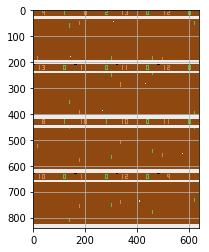

---------------------------------
| ep_len_mean        | 919      |
| ep_reward_mean     | -20.4    |
| explained_variance | -0.0695  |
| fps                | 484      |
| nupdates           | 200      |
| policy_entropy     | 1.79     |
| total_timesteps    | 16200    |
| value_loss         | 0.0489   |
---------------------------------


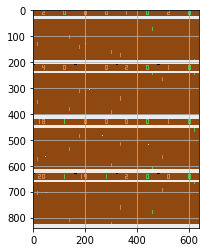

---------------------------------
| ep_len_mean        | 954      |
| ep_reward_mean     | -20.2    |
| explained_variance | 0.0787   |
| fps                | 495      |
| nupdates           | 300      |
| policy_entropy     | 1.79     |
| total_timesteps    | 24300    |
| value_loss         | 0.0523   |
---------------------------------


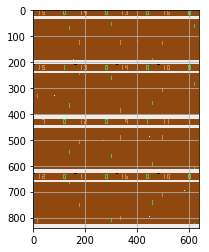

---------------------------------
| ep_len_mean        | 924      |
| ep_reward_mean     | -20.5    |
| explained_variance | -0.133   |
| fps                | 500      |
| nupdates           | 400      |
| policy_entropy     | 1.79     |
| total_timesteps    | 32400    |
| value_loss         | 0.0446   |
---------------------------------


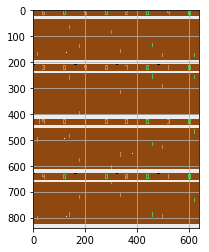

---------------------------------
| ep_len_mean        | 917      |
| ep_reward_mean     | -20.5    |
| explained_variance | 0.0296   |
| fps                | 503      |
| nupdates           | 500      |
| policy_entropy     | 1.79     |
| total_timesteps    | 40500    |
| value_loss         | 0.0811   |
---------------------------------


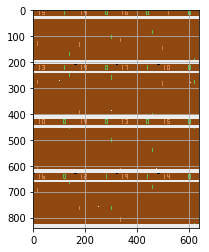

---------------------------------
| ep_len_mean        | 912      |
| ep_reward_mean     | -20.5    |
| explained_variance | 0.1      |
| fps                | 505      |
| nupdates           | 600      |
| policy_entropy     | 1.79     |
| total_timesteps    | 48600    |
| value_loss         | 0.0499   |
---------------------------------


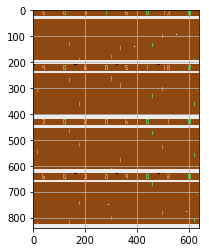

---------------------------------
| ep_len_mean        | 916      |
| ep_reward_mean     | -20.4    |
| explained_variance | -0.0216  |
| fps                | 507      |
| nupdates           | 700      |
| policy_entropy     | 1.79     |
| total_timesteps    | 56700    |
| value_loss         | 0.155    |
---------------------------------


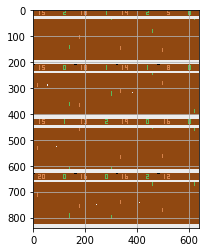

---------------------------------
| ep_len_mean        | 928      |
| ep_reward_mean     | -20.3    |
| explained_variance | -0.0818  |
| fps                | 508      |
| nupdates           | 800      |
| policy_entropy     | 1.79     |
| total_timesteps    | 64800    |
| value_loss         | 0.0454   |
---------------------------------


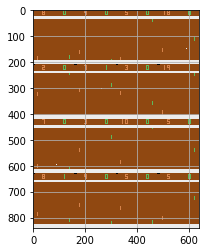

---------------------------------
| ep_len_mean        | 926      |
| ep_reward_mean     | -20.3    |
| explained_variance | -0.00862 |
| fps                | 510      |
| nupdates           | 900      |
| policy_entropy     | 1.79     |
| total_timesteps    | 72900    |
| value_loss         | 0.0842   |
---------------------------------


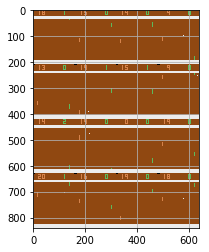

---------------------------------
| ep_len_mean        | 929      |
| ep_reward_mean     | -20.3    |
| explained_variance | 0.0587   |
| fps                | 510      |
| nupdates           | 1000     |
| policy_entropy     | 1.79     |
| total_timesteps    | 81000    |
| value_loss         | 0.0954   |
---------------------------------


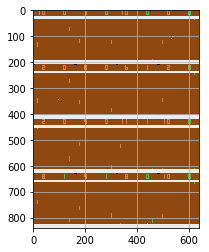

---------------------------------
| ep_len_mean        | 922      |
| ep_reward_mean     | -20.3    |
| explained_variance | -0.569   |
| fps                | 511      |
| nupdates           | 1100     |
| policy_entropy     | 1.79     |
| total_timesteps    | 89100    |
| value_loss         | 0.00396  |
---------------------------------


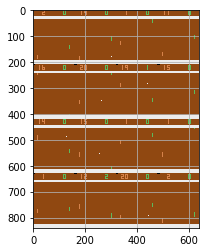

---------------------------------
| ep_len_mean        | 923      |
| ep_reward_mean     | -20.4    |
| explained_variance | 0.0584   |
| fps                | 512      |
| nupdates           | 1200     |
| policy_entropy     | 1.79     |
| total_timesteps    | 97200    |
| value_loss         | 0.0589   |
---------------------------------


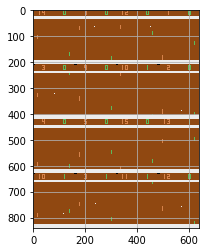

---------------------------------
| ep_len_mean        | 926      |
| ep_reward_mean     | -20.4    |
| explained_variance | -0.0662  |
| fps                | 513      |
| nupdates           | 1300     |
| policy_entropy     | 1.79     |
| total_timesteps    | 105300   |
| value_loss         | 0.159    |
---------------------------------


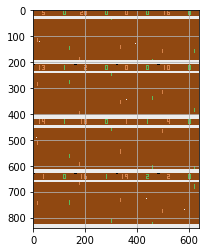

---------------------------------
| ep_len_mean        | 929      |
| ep_reward_mean     | -20.4    |
| explained_variance | -0.053   |
| fps                | 514      |
| nupdates           | 1400     |
| policy_entropy     | 1.79     |
| total_timesteps    | 113400   |
| value_loss         | 0.0663   |
---------------------------------


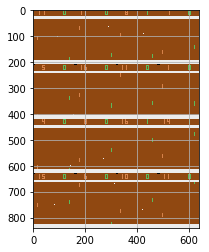

---------------------------------
| ep_len_mean        | 927      |
| ep_reward_mean     | -20.4    |
| explained_variance | 0.0182   |
| fps                | 515      |
| nupdates           | 1500     |
| policy_entropy     | 1.79     |
| total_timesteps    | 121500   |
| value_loss         | 0.0556   |
---------------------------------


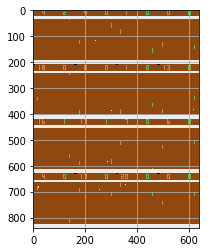

---------------------------------
| ep_len_mean        | 927      |
| ep_reward_mean     | -20.4    |
| explained_variance | 0.0457   |
| fps                | 516      |
| nupdates           | 1600     |
| policy_entropy     | 1.78     |
| total_timesteps    | 129600   |
| value_loss         | 0.0586   |
---------------------------------


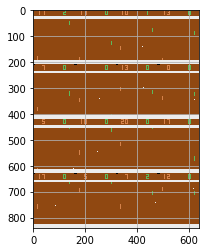

In [0]:
env = make_atari_env('PongNoFrameskip-v4', num_env=16, seed=0)

env = VecFrameStack(env, n_stack=4) # stack 4 frames
model = A2C(CnnPolicy, env, lr_schedule='constant', verbose=1, policy_kwargs={'cnn_extractor': attention_cnn})
model.learn(total_timesteps=int(1e5), callback=callback)